In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

In [3]:
fft_size = 1024
avg_freq_axis = 2
avg_time_axis = 1

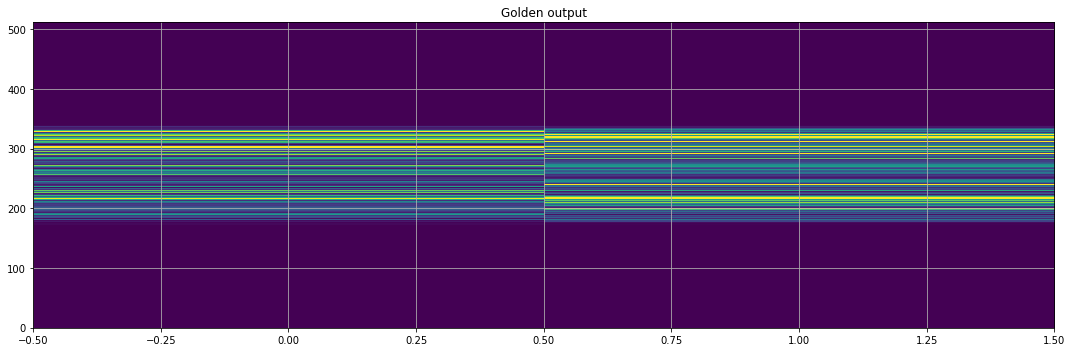

In [4]:
from pyhacores.utils import *
from scipy import signal
file = '/home/gaspar/git/pyhacores/data/f2404_fs16.896_one_hop.iq'
# Note: sample count must be divisible with fft_size!
orig_inp = load_iq(file)[10000:12048]

orig_inp -= np.mean(orig_inp)

_, _, spectro_out = signal.spectrogram(orig_inp, 1, nperseg=fft_size, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_size//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // avg_freq_axis)
golden_output = np.average(x, axis=1)

plt.title('Golden output')
imshow(golden_output)

In [5]:
orig_inp.shape

(2048,)

# DC Removal

In [6]:
from pyhacores.filter import DCRemoval
dut = DCRemoval(256, dtype=Complex)
sims0 = simulate(dut, orig_inp.T, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2049/2049 [00:00<00:00, 6716.00it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [7]:
snr(sims0['MODEL'], sims0['PYHA'])

52.594400559892556

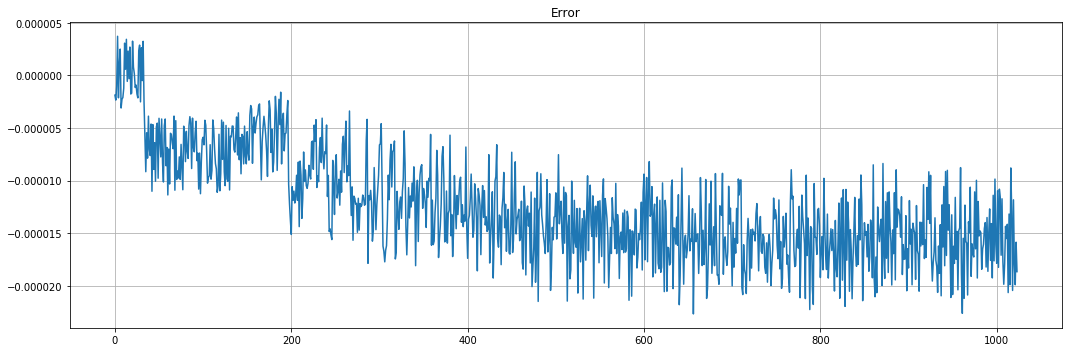

In [8]:
plt.title('Error')
plt.plot(sims0['MODEL'][:fft_size] - sims0['PYHA'][:fft_size])
show_plot()

# Packager

In [9]:
from pyhacores.fft import Packager
dut = Packager(fft_size)
sims1 = simulate(dut, sims0['MODEL'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2049/2049 [00:00<00:00, 22292.88it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [10]:
snr(sims1['MODEL'], sims1['PYHA'])

69.11250990032175

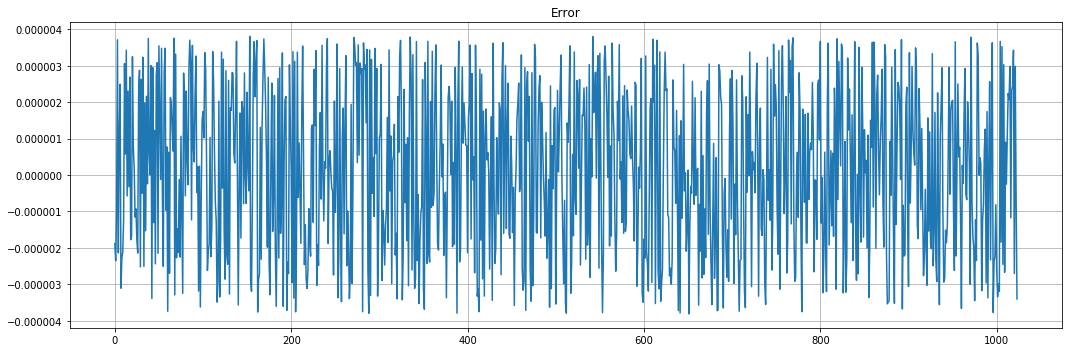

In [11]:
plt.title('Error')
plt.plot(sims1['MODEL'][0] - sims1['PYHA'][0])
show_plot()

# Windower

In [12]:
from pyhacores.fft import Windower
dut = Windower(fft_size, coefficient_bits=8)
sims2 = simulate(dut, sims1['MODEL'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2049/2049 [00:00<00:00, 19058.08it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [13]:
snr(sims2['MODEL'], sims2['PYHA'])

46.328415098563795

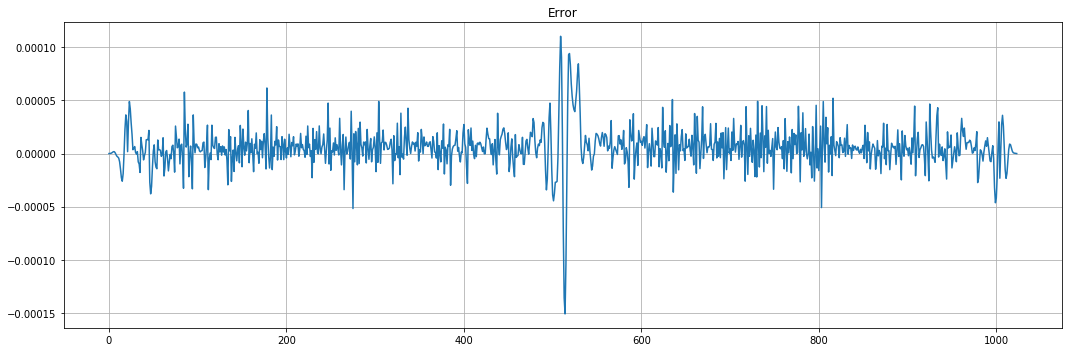

In [14]:
plt.title('Error')
plt.plot(sims2['MODEL'][0] - sims2['PYHA'][0])
show_plot()

# FFT

In [15]:
from pyhacores.fft import R2SDF
dut = R2SDF(fft_size, twiddle_bits=8)
sims3 = simulate(dut, sims2['MODEL'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 3102/3102 [00:02<00:00, 1513.96it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [16]:
snr(sims3['MODEL'], sims3['PYHA'])

33.11984923959295

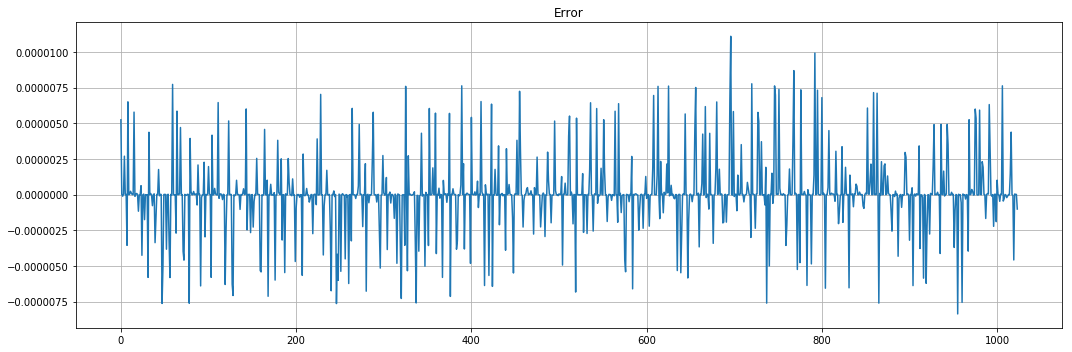

In [17]:
plt.title('Error')
plt.plot(sims3['MODEL'][0] - sims3['PYHA'][0])
show_plot()

# FFT to power

In [18]:
from pyhacores.fft import FFTPower
dut = FFTPower()
sims4 = simulate(dut, sims3['MODEL'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2049/2049 [00:00<00:00, 18289.08it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [19]:
snr(sims4['MODEL'], sims4['PYHA'])

33.05218735467791

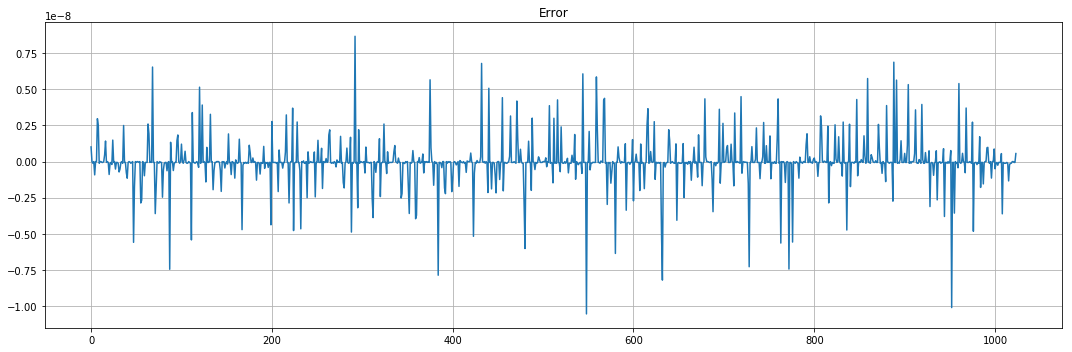

In [20]:
plt.title('Error')
plt.plot(sims4['MODEL'][0] - sims4['PYHA'][0])
show_plot()

# Bitrverse, FFTShift, AVGPool

In [21]:
from pyhacores.fft import BitreversalFFTshiftAVGPool
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis, avg_time_axis)
sims5 = simulate(dut, sims4['MODEL'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 3073/3073 [00:00<00:00, 23119.33it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [22]:
snr(sims5['MODEL'], sims5['PYHA'])

70.49429367976478

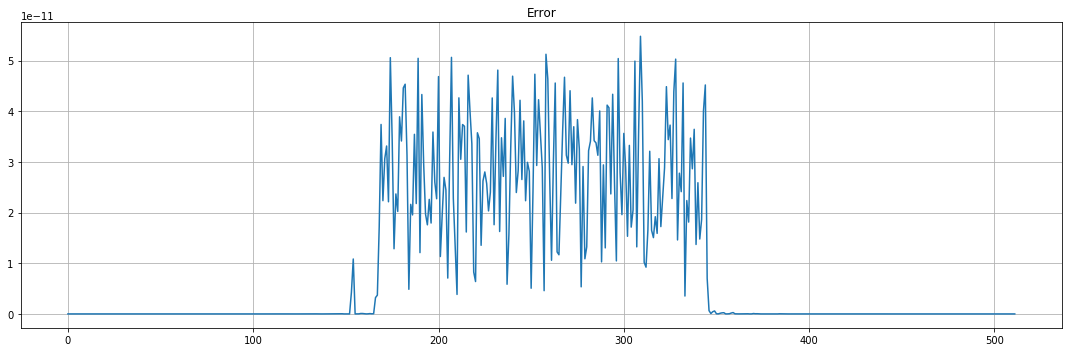

In [23]:
plt.title('Error')
plt.plot(sims5['MODEL'][0] - sims5['PYHA'][0])
show_plot()